# ETL para datos de ecobici CDMX

#  0. Cargar librerías

In [59]:
# Importar librerías
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba.core.ir_utils import tuple_table_extensions

# 1. Extracción

In [60]:
# 1) cargar datos
# Definir ruta de datos
data = "2025-06.csv"
data_frame = pd.read_csv(data)

#ver la forma de la data
print("\nDimensiones del DataFrame:", data_frame.shape)
print("\nColumnas del DataFrame:", data_frame.columns)
print("\nTipos de datos:\n", data_frame.dtypes)


Dimensiones del DataFrame: (1578804, 9)

Columnas del DataFrame: Index(['Genero_Usuario', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro',
       'Fecha_Retiro', 'Hora_Retiro', 'Ciclo_EstacionArribo', 'Fecha_Arribo',
       'Hora_Arribo'],
      dtype='object')

Tipos de datos:
 Genero_Usuario            object
Edad_Usuario             float64
Bici                       int64
Ciclo_Estacion_Retiro     object
Fecha_Retiro              object
Hora_Retiro               object
Ciclo_EstacionArribo      object
Fecha_Arribo              object
Hora_Arribo               object
dtype: object


In [61]:
# Mostrar las primeras filas del DataFrame
print("\nPrimeras filas del DataFrame:\n")
data_frame.head()


Primeras filas del DataFrame:



,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo
0,M,30.0,8384919,552,31/05/2025,23:52:42,491,01/06/2025,00:00:06
1,F,34.0,4275616,138,31/05/2025,23:34:45,036,01/06/2025,00:00:37
2,M,27.0,8370249,596,31/05/2025,23:51:42,618,01/06/2025,00:01:17
3,M,27.0,3430139,304,31/05/2025,23:46:27,578,01/06/2025,00:01:17
4,M,37.0,8102766,546,31/05/2025,23:45:14,052,01/06/2025,00:01:27


# 2. Transformación

In [62]:
# 2) limpieza base de los datos

if not isinstance(data_frame, pd.DataFrame):
    data_frame = pd.read_csv("2025-06.csv")

# columnas normales
if not isinstance(data_frame.columns, pd.MultiIndex):
    data_frame.rename(
        columns=lambda c: c.strip().replace(" ", "_") if isinstance(c, str) else c,
        inplace=True
    )
# columnas tipo MultiIndex
else:
    data_frame.columns = [
        "_".join([str(x).strip() for x in col if str(x) != "None"]).replace(" ", "_")
        for col in data_frame.columns
    ]

# manejo de valores nulos en la columna Genero_Usuario
if "Genero_Usuario" in data_frame.columns:
    data_frame["Genero_Usuario"] = (
        data_frame["Genero_Usuario"]
        .astype(str)
        .str.strip()
        .fillna("Desconocido")
    )

#edad a numerico, manejo de nan, se usa mediana para reemplazar
if "Edad_Usuario" in data_frame.columns:
    data_frame["Edad_Usuario"] = pd.to_numeric(data_frame["Edad_Usuario"], errors="coerce")
    data_frame.loc[(data_frame["Edad_Usuario"] < 10) | (data_frame["Edad_Usuario"] > 90), "Edad_Usuario"] = np.nan
    med_edad = data_frame["Edad_Usuario"].median()
    data_frame["Edad_Usuario"] = data_frame["Edad_Usuario"].fillna(med_edad)

In [63]:
# 3) fecha  y horas a formato datetime

fmt = "%d/%m/%Y %H:%M:%S"

def a_dt(data_frame_local, f_col, h_col, fmt):
    s = data_frame_local[f_col].astype(str).str.strip() + " " + data_frame_local[h_col].astype(str).str.strip()
    return pd.to_datetime(s, format=fmt, errors="coerce")

data_frame["fh_ret"] = a_dt(data_frame, "Fecha_Retiro", "Hora_Retiro", fmt)
data_frame["fh_arr"] = a_dt(data_frame, "Fecha_Arribo", "Hora_Arribo", fmt)

# opcional: chequear nulos
print("NaT fh_ret:", data_frame["fh_ret"].isna().sum(), "NaT fh_arr:", data_frame["fh_arr"].isna().sum())


NaT fh_ret: 0 NaT fh_arr: 0


In [64]:
# 4) Duración y calidad del viaje
data_frame["dur_min"] = (data_frame["fh_arr"] - data_frame["fh_ret"]).dt.total_seconds() / 60

# para que un viaje sea considerado como bueno
# se debe cumplir: 0 < duracion <= 240 min
data_frame["ok"] = (data_frame["dur_min"] > 0) & (data_frame["dur_min"] <= 240)
data_frame = data_frame.loc[data_frame["ok"]].copy()

print("filas ok:", len(data_frame), "filas descartadas:", (~data_frame["ok"]).sum())


filas ok: 1578297 filas descartadas: 0


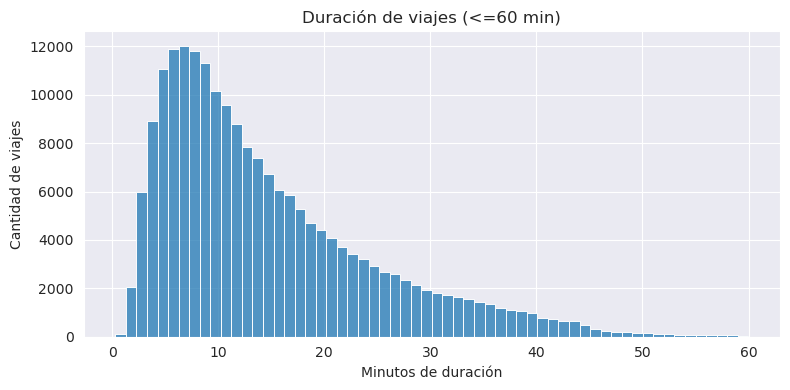

In [65]:
SEED = 42

# --- 4b) Gráfica histograma de duración ---
m = data_frame.loc[data_frame["dur_min"].between(0, 60)]
if len(m) > 200_000:
    m = m.sample(200_000, random_state=SEED)

plt.figure(figsize=(8,4))
sns.histplot(m["dur_min"], bins=60)
plt.title("Duración de viajes (<=60 min)")
plt.xlabel("Minutos de duración")
plt.ylabel("Cantidad de viajes")
plt.tight_layout()
plt.show()

In [66]:
# 5) Estaciones a IDs numéricos
def id_num(serie):
    return pd.to_numeric(serie.astype(str).str.extract(r"(\d+)")[0], errors="coerce")

data_frame["est_ret_id"] = id_num(data_frame["Ciclo_Estacion_Retiro"])
data_frame["est_arr_id"] = id_num(data_frame["Ciclo_EstacionArribo"])

# cheacar valores nulos
print("nulos est_ret_id:", data_frame["est_ret_id"].isna().sum(), "nulos est_arr_id:", data_frame["est_arr_id"].isna().sum())


nulos est_ret_id: 0 nulos est_arr_id: 0


In [67]:
# 6) Normalizar  género
data_frame = pd.read_csv("2025-06.csv")

mapa_genero = {
    "M": "Masculino", "H": "Masculino", "HOMBRE": "Masculino",
    "F": "Femenino", "MUJER": "Femenino",
    "OTRO": "Otro", "X": "Otro", "DESCONOCIDO": "Desconocido"
}

genero = data_frame["Genero_Usuario"].astype(str).str.upper().str.strip()
data_frame["gen"] = genero.map(mapa_genero).fillna(data_frame["Genero_Usuario"])
map_gen_cod = {"Femenino": 0, "Masculino": 1, "Otro": 2, "Desconocido": 3}
data_frame["gen_cod"] = data_frame["gen"].map(map_gen_cod).fillna(3).astype(int)

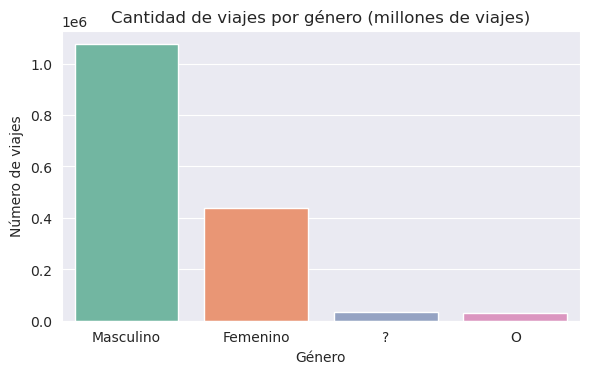

In [73]:
# --- 6b) Gráfica cantidad de viajes por género (corregido) ---
conteo_gen = data_frame["gen"].value_counts().reset_index()
conteo_gen.columns = ["gen", "viajes"]

plt.figure(figsize=(6,4))
sns.barplot(data=conteo_gen, x="gen", y="viajes", hue="gen", palette="Set2", legend=False)
plt.title("Cantidad de viajes por género (millones de viajes)")
plt.xlabel("Género")
plt.ylabel("Número de viajes")
plt.tight_layout()
plt.show()


In [68]:
# 7) Featurue engineering
fmt = "%d/%m/%Y %H:%M:%S"

def a_dt(data_frame_local, f_col, h_col, fmt):
    s = data_frame_local[f_col].astype(str).str.strip() + " " + data_frame_local[h_col].astype(str).str.strip()
    return pd.to_datetime(s, format=fmt, errors="coerce")

data_frame["fh_ret"] = a_dt(data_frame, "Fecha_Retiro", "Hora_Retiro", fmt)
data_frame["fh_arr"] = a_dt(data_frame, "Fecha_Arribo", "Hora_Arribo", fmt)

data_frame["dur_min"] = (data_frame["fh_arr"] - data_frame["fh_ret"]).dt.total_seconds() / 60

if data_frame["dur_min"].isna().any():
    print("Warning: Missing or invalid durations detected in 'dur_min'.")

#temporales
data_frame["hora"] = data_frame["fh_ret"].dt.hour
data_frame["dia_sem"] = data_frame["fh_ret"].dt.dayofweek
data_frame["mes"] = data_frame["fh_ret"].dt.month

# edad a grupos
bins = [0, 18, 30, 45, 60, 90]
etiquetas_edad = ["adolescente", "joven", "adulto", "senor", "mayor"]
data_frame['grp_edad'] = pd.cut(data_frame["Edad_Usuario"], bins=bins, labels=etiquetas_edad, right=False)

#tramos de duracion del viaje
bins_dur = [-1, 10, 20, 30, 45, 60, 120, 240]
etiquetas_dur = ["muy_corto", "corto", "medio", "largo", "muy_largo", "extenso", "muy_extenso"]
data_frame["grp_dur"] = pd.cut(data_frame["dur_min"], bins=bins_dur, labels=etiquetas_dur, right=True)

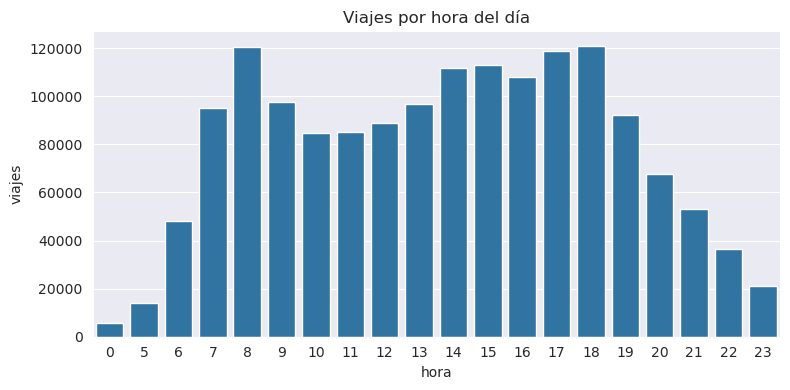

In [69]:
# 7a) Gráfica viajes por hora
vph = data_frame.groupby("hora").size().rename("viajes").reset_index()
plt.figure(figsize=(8,4))
sns.barplot(data=vph, x="hora", y="viajes")
plt.title("Viajes por hora del día")
plt.xlabel("hora")
plt.ylabel("viajes")
plt.tight_layout()
plt.show()

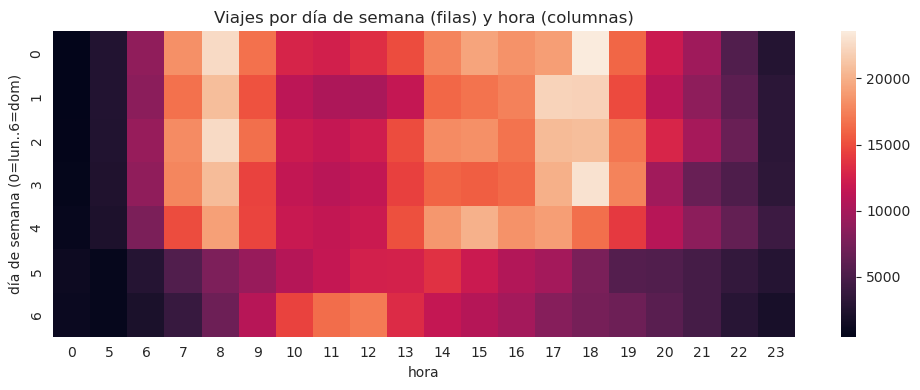

In [70]:
# 7b) Gráfica heatmap hora x día
tbl = (data_frame.groupby(["dia_sem", "hora"])
          .size()
          .rename("n")
          .reset_index()
          .pivot(index="dia_sem", columns="hora", values="n")
          .fillna(0))

plt.figure(figsize=(10,4))
sns.heatmap(tbl, annot=False)
plt.title("Viajes por día de semana (filas) y hora (columnas)")
plt.xlabel("hora")
plt.ylabel("día de semana (0=lun..6=dom)")
plt.tight_layout()
plt.show()



# 3. Carga


In [71]:
# 8) Guardar datos limpios

columnas_a_guardar = [
    # claves
    "Bici", "est_ret_id", "est_arr_id",
    # usuario
    "Genero_Usuario", "gen", "gen_cod", "Edad_Usuario",
    # tiempo
    "fh_ret", "fh_arr", "dur_min", "grp_dur",
    "hora", "dia_sem", "fin_sem", "grp_edad",
    "Ciclo_Estacion_Retiro", "Ciclo_EstacionArribo",
    "Fecha_Retiro", "Hora_Retiro", "Fecha_Arribo", "Hora_Arribo"
]
columnas_a_guardar = [col for col in columnas_a_guardar if col in data_frame.columns]

data_frame_limpio = data_frame[columnas_a_guardar].copy()

ruta_salida = "2024-06_limpio.csv"
data_frame_limpio.to_csv(ruta_salida, index=False)
print("Datos limpios guardados en: ", os.path.abspath(ruta_salida))

Datos limpios guardados en:  /home/brunene/Documents/ITESM/Module 1. Statistics for data science/2024-06_limpio.csv


In [80]:
data_frame_limpio

,Bici,Genero_Usuario,gen,gen_cod,Edad_Usuario,fh_ret,fh_arr,dur_min,grp_dur,hora,dia_sem,grp_edad,Ciclo_Estacion_Retiro,Ciclo_EstacionArribo,Fecha_Retiro,Hora_Retiro,Fecha_Arribo,Hora_Arribo
0,8384919,M,Masculino,1,30.0,2025-05-31 23:52:42,2025-06-01 00:00:06,7.400000,muy_corto,23,5,adulto,552,491,31/05/2025,23:52:42,01/06/2025,00:00:06
1,4275616,F,Femenino,0,34.0,2025-05-31 23:34:45,2025-06-01 00:00:37,25.866667,medio,23,5,adulto,138,036,31/05/2025,23:34:45,01/06/2025,00:00:37
2,8370249,M,Masculino,1,27.0,2025-05-31 23:51:42,2025-06-01 00:01:17,9.583333,muy_corto,23,5,joven,596,618,31/05/2025,23:51:42,01/06/2025,00:01:17
3,3430139,M,Masculino,1,27.0,2025-05-31 23:46:27,2025-06-01 00:01:17,14.833333,corto,23,5,joven,304,578,31/05/2025,23:46:27,01/06/2025,00:01:17
4,8102766,M,Masculino,1,37.0,2025-05-31 23:45:14,2025-06-01 00:01:27,16.216667,corto,23,5,adulto,546,052,31/05/2025,23:45:14,01/06/2025,00:01:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578799,3499332,M,Masculino,1,30.0,2025-06-30 23:46:31,2025-06-30 23:59:20,12.816667,corto,23,0,adulto,034,570,30/06/2025,23:46:31,30/06/2025,23:59:20
1578800,7103211,F,Femenino,0,42.0,2025-06-30 23:52:42,2025-06-30 23:59:24,6.700000,muy_corto,23,0,adulto,021,071,30/06/2025,23:52:42,30/06/2025,23:59:24
1578801,4275772,F,Femenino,0,24.0,2025-06-30 23:48:53,2025-06-30 23:59:30,10.616667,corto,23,0,joven,547,259,30/06/2025,23:48:53,30/06/2025,23:59:30
1578802,8124844,M,Masculino,1,24.0,2025-06-30 23:48:32,2025-06-30 23:59:34,11.033333,corto,23,0,joven,547,259,30/06/2025,23:48:32,30/06/2025,23:59:34
